In [1]:
import os
from os.path import join
import sys
sys.path.insert(0, "/opt/src")
from dfba import DfbaModel, ExchangeFlux, KineticVariable, ControlParameter
from plotly import graph_objects as go
from functools import partial
from dfba.plot.plotly import *
from ExpGSMM.experimental.ExpMatrix import *
from ExpGSMM.model.COBRAmodel import MyModel
import sympy as sp
from sympy import Max, Min
from sympy.functions import Abs
from ExpGSMM import DATA_PATH
import json
from joblib import Parallel
import numbers
import matplotlib.pyplot as plt

In [372]:
def read_model():
    fba_model = MyModel(join(DATA_PATH, "models/model_dfba.xml"), "e_ActiveBiomass__cytop")
    fba_model.exchanges.EX_C00011__dra.bounds = (-10000, 10000)
    fba_model.solver = "glpk"
    [setattr(x, 'objective_coefficient', 0) for x in fba_model.reactions if x.objective_coefficient != 0]

    objectives = {"e_ActiveBiomass__cytop": 1, "DM_C00369__chlo": 1, "DM_C05306__chlo": 1, 
                  "DM_C05307__chlo": 1, "DM_C02094__chlo": 1, "DM_C00116__cytop": 1, "DM_C00422__lip": 1
                  , "EX_C00244__dra": -1
                  , "EX_C00009__dra": -1
#                   ,"DM_C00244__cytop":1
                 }

    for reaction_id, value in objectives.items():
        fba_model.reactions.get_by_id(reaction_id).objective_coefficient = value
    return fba_model

fba_model = read_model()
matrix = ExpMatrix(f"{DATA_PATH}/experimental/Matriz- DCCR Dunaliella salina_dfba.xlsx")
matrix.conditions = "Resume"

Loading

Reactions: 3512
Metabolites: 3660
Genes: 1690
Model loaded


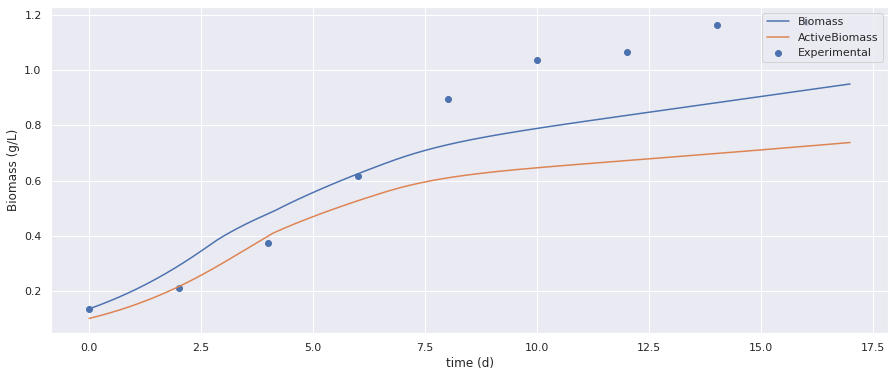

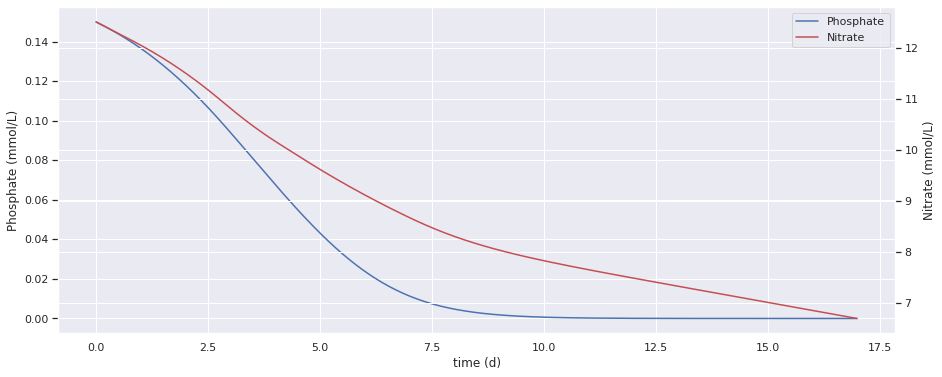

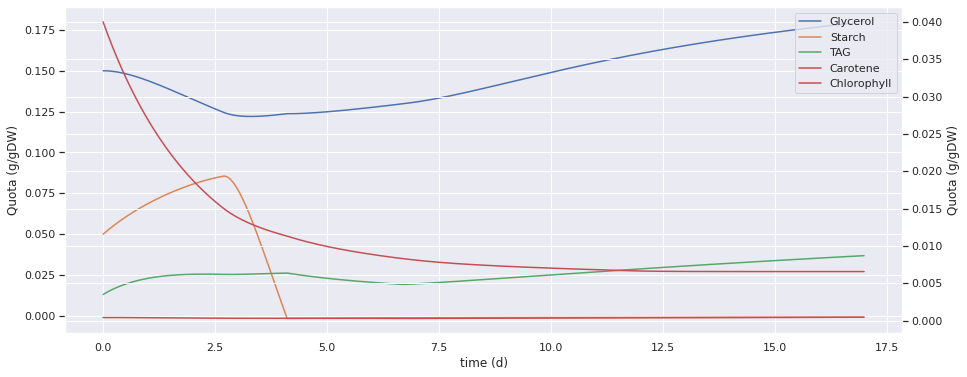

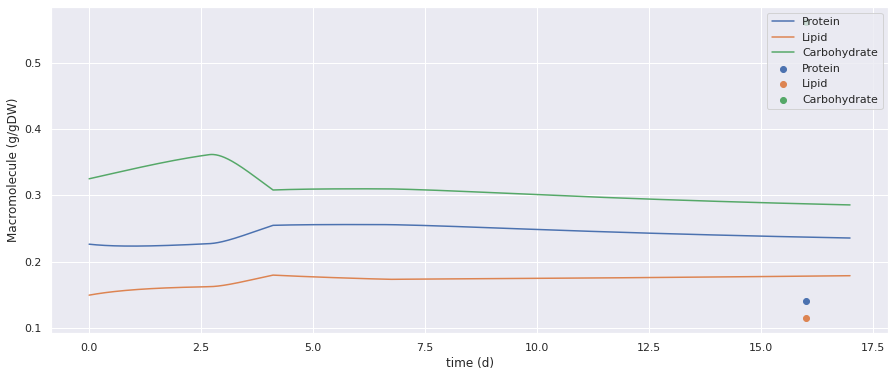

In [373]:
##### import os
from os.path import join
import sys
from dfba import DfbaModel, ExchangeFlux, KineticVariable
from plotly import graph_objects as go

sys.path.insert(0, "/home/src/")

from ExpGSMM.experimental.ExpMatrix import *
from ExpGSMM.model.COBRAmodel import MyModel
from ExpGSMM.dynamic.initial_conditions import get_initial_conditions
from ExpGSMM.dynamic.rhs import get_bounds
import sympy as sp
from sympy import Max, Min
from sympy.functions import Abs
from ExpGSMM.graphics.plot import plot_concentrations, plot_trajectories

def get_kinetic_variables():
    light = KineticVariable("Light")
    X = KineticVariable("Biomass")
    F = KineticVariable("ActiveBiomass")
    nitrate = KineticVariable("Nitrate")
    n_quota = KineticVariable("Nitrogen_quota")
    phosphorus = KineticVariable("Phosphate")
    p_quota = KineticVariable("Phosphate_quota")
    starch = KineticVariable("Starch")
    starch_concentration = KineticVariable("Starch_concentration")
    tag = KineticVariable("TAG")
    glycerol = KineticVariable("Glycerol")
    carotene = KineticVariable("Carotene")
    chlorophyll = KineticVariable("Chlorophyll")
    return [X, F, nitrate, phosphorus, starch, starch_concentration, chlorophyll, carotene, n_quota, p_quota, tag, glycerol, light]


def create_dfba_model(condition, parameters, create_plots=False):
    if 'Time (d)' not in matrix.matrix[condition].columns:
        matrix.matrix[condition]['Time (d)'] = matrix.matrix[condition].index
    dfba_model = DfbaModel(fba_model)
#     dfba_model.solver_data.set_display("none")
    dfba_model.solver_data.set_algorithm("direct")
#     dfba_model.solver_data.set_rel_tolerance(1e-3)
    #     dfba_model.solver_data.set_ode_method("ADAMS")

    X, F, nitrate, phosphorus, starch, starch_concentration, chlorophyll, carotene, n_quota, p_quota, tag, glycerol, light = get_kinetic_variables()
    dfba_model.add_kinetic_variables([X, F, nitrate, phosphorus, starch, starch_concentration, chlorophyll, carotene, n_quota, p_quota, tag, glycerol, light])

    mu = ExchangeFlux(f"e_ActiveBiomass__cytop")
    light_uptake = ExchangeFlux("EX_C00205__dra")
    v_N = ExchangeFlux("EX_C00244__dra")
    v_CO2 = ExchangeFlux("EX_C00011__dra")
    v_P = ExchangeFlux("EX_C00009__dra")
    v_S = ExchangeFlux("DM_C00369__chlo")
    v_tag = ExchangeFlux("DM_C00422__lip")
    v_C = ExchangeFlux("DM_C02094__chlo")
    v_chla = ExchangeFlux("DM_C05306__chlo")
    v_chlb = ExchangeFlux("DM_C05307__chlo")
    v_glycerol = ExchangeFlux("DM_C00116__cytop")
    v_intraP = ExchangeFlux("DM_C00404__vacu")
    v_intraN = ExchangeFlux("DM_C00244__cytop")

    dfba_model.add_exchange_fluxes([mu, v_P, v_CO2, v_S, v_C, v_chla, v_chlb, v_tag, v_N, v_glycerol, light_uptake, v_intraP, v_intraN])
    starch_production = v_S * 48660.195 / 1000
    chl_production = v_chla * 893.49 / 1000 + v_chlb * 907.49 / 1000
    caro_production = v_C * 536.87 / 1000
    glycerol_production = v_glycerol * 92.09 / 1000
    tag_production = v_tag * 904.78 / 1000
    total_growth_rate = mu + starch_production + chl_production + caro_production + glycerol_production + tag_production

    dfba_model.add_rhs_expression("ActiveBiomass", mu * X)
    dfba_model.add_rhs_expression("Biomass", total_growth_rate * X)
    dfba_model.add_rhs_expression("Nitrogen_quota", -v_N - total_growth_rate * n_quota)
    dfba_model.add_rhs_expression("Phosphate_quota", -v_P - total_growth_rate * p_quota)
    dfba_model.add_rhs_expression("Light", 0)
    dfba_model.add_rhs_expression("Nitrate", v_N * X)
    dfba_model.add_rhs_expression("Phosphate", v_P * X)
    dfba_model.add_rhs_expression("Starch", starch_production - total_growth_rate * starch)
    dfba_model.add_rhs_expression("Starch_concentration", starch_production * X)
    dfba_model.add_rhs_expression("TAG", tag_production - total_growth_rate * tag)
    dfba_model.add_rhs_expression("Glycerol", glycerol_production - total_growth_rate * glycerol)
    dfba_model.add_rhs_expression("Carotene", caro_production - total_growth_rate * carotene)
    dfba_model.add_rhs_expression("Chlorophyll", chl_production - total_growth_rate * chlorophyll)
    ##### Optimization ######
    ro1 = parameters["ro1"]
    ro0 = parameters["ro0"]
    a0 = parameters["a0"]
    a1 = parameters["a1"]
    a2 = parameters["a2"]
    a3 = parameters["a3"]
    a4 = parameters["a4"]
    ExA = parameters["ExA"]
    l = parameters["l"]
    smoothing_factor = parameters["smoothing_factor"]
    wPopt = parameters["wPopt"]
    wPmin = parameters["wPmin"]
    wNmin = parameters["wNmin"]
    wNmax = parameters["wNmax"]
    c0 = parameters["c0"]
    t_max = parameters["t_max"]
    K_nitrogen_quota = parameters["K_nitrogen_quota"]
    VPmax = parameters["VPmax"]
    KPm = parameters["KPm"]
    VNmax = parameters["VNmax"]
    KNm = parameters["KNm"]
    wgly_max = parameters["wgly_max"]
    maximum_starch_production = parameters["maximum_starch_production"]
    maximum_tag_production = parameters["maximum_tag_production"]
    v_nitrate_max = parameters["v_nitrate_max"]
    v_polyphosphate_max = parameters["v_polyphosphate_max"]
    v_car_max = parameters["v_car_max"]
    ymax = parameters["ymax"]
    Esat = parameters["Esat"]
    KEchl = parameters["KEchl"]
    vco2max = parameters["vco2max"]
    Kstl = parameters["Kstl"]
    hill_coeff_starch = parameters["hill_coeff_starch"]

    ##### Experiment-dependent ######
    Eo =matrix.conditions["Light (umol/m^2.s)"].loc[condition]
    nacl = matrix.conditions["Salinity g/L"].loc[condition]
    Lr = matrix.conditions["Lr"].loc[condition]
    aeration = matrix.conditions["Aeration rate"].loc[condition]
    
    light_sources = matrix.conditions["Light sources"].loc[condition].split(",")
    for light_source in light_sources:
        fba_model.reactions.get_by_id(light_source).bounds = (0, 10000)

    ##### General ######
    q = n_quota / wNmax
    n = 1 - (q / (q + K_nitrogen_quota))
    x_storage = starch + carotene + glycerol + tag
    T = 1 / (1 - x_storage)
    z = (T - 1) / (t_max - 1)
    nitrogen_mass_quota = n_quota * 14.01 / 1000
    phosphate_mass_quota = p_quota * 30.97 / 1000

    ##### Light ######
    Ke = 11.5 * X * chlorophyll
    Ex = Eo / (Lr * Ke) * (1 - sp.exp(-Lr * Ke))
    ro = ro1 * chlorophyll + ro0
    Ex = ro / (X * Lr) * Ex * parameters["light_conversion_factor"]
    dfba_model.add_exchange_flux_lb("EX_C00205__dra", sp.Max(sp.N(Ex), 0), light)

    ##### NO3 ######
    dfba_model.add_exchange_flux_lb("EX_C00244__dra", sp.Max(VNmax * nitrate / (KNm + nitrate) * (1 - q),0), nitrate)  # 4.07
#     nitrate_quota = sp.Max(0, 1 - (4.8697 * F / X) / n_quota)
    dfba_model.add_exchange_flux_lb("DM_C00244__cytop",sp.Max(0,  v_nitrate_max * (1 - wNmin/n_quota)), nitrate)
    dfba_model.add_exchange_flux_ub("DM_C00244__cytop", 0, nitrate)

    ##### HPO4 ######
    dfba_model.add_exchange_flux_lb("EX_C00009__dra", sp.Max(0, VPmax * phosphorus / (KPm + phosphorus)), phosphorus)
#     polyP_quota = sp.Max(0, 1 - (0.295 * F / X) / p_quota)
#     dfba_model.add_exchange_flux_lb("DM_C00404__vacu", sp.Max(0, v_polyphosphate_max * (1-polyP_quota)), phosphorus)
    dfba_model.add_exchange_flux_lb("DM_C00404__vacu", sp.Max(0, v_polyphosphate_max * (1-wPmin/p_quota)), phosphorus)

    ##### Starch ######
    Ks = 0.034
    vmax = 0.066 / 48660.195 * 1000
    from sympy import N
    dfba_model.add_exchange_flux_lb("DM_C00369__chlo", sp.Max(0, N(vmax * sp.Max(0, starch_concentration)/ (sp.Max(0, starch_concentration) + Ks)), 5), starch)
    light_factor = Ex**hill_coeff_starch / (Kstl**hill_coeff_starch + Ex**hill_coeff_starch)
    dfba_model.add_exchange_flux_ub("DM_C00369__chlo", sp.Max(0, maximum_starch_production*(1 - z)*light_factor), starch) # 

    ##### Carotene ######

    def phi(x, rs):
        return 1 / (1 + sp.exp(-rs * x))
    v_car_gen = v_car_max * (Ex ** l) / ((ExA ** l) + (Ex ** l))
#     phosphate_factor = ((p_quota - wPmin) / (wPopt - wPmin))
#     temp=1.5
#     p = p_quota**temp / (p_quota**temp+a2**temp)
    
#     vcar = v_car_gen *  sp.Max(0, phi(a1 * Ex + a0 - a2 * nitrogen_mass_quota, smoothing_factor)) * (1-wPmin/p_quota) #* phi(-a4*aeration, 4)   # sp.Max(0, phi(a1 * Ex + a0 - a2 * nitrogen_mass_quota, smoothing_factor)) * (1-wPmin/p_quota) #* phi(-a4*aeration, 4)     #phi(a3 * p_quota, 8)  - a4*aeration  + a3*phosphate_mass_quota - a4*aeration
    vcar = v_car_gen * phi(a1 * Ex + a0 - a2 * nitrogen_mass_quota + a3 * phosphate_mass_quota - a4 * aeration, smoothing_factor)
    dfba_model.add_exchange_flux_ub("DM_C02094__chlo", vcar, carotene)
    ##### Chlorophyll ######
    phosphate_factor = ((p_quota - wPmin) / (wPopt - wPmin)) + c0

    def gamma(E):
        if E > Esat: E = Esat
        return ymax * (KEchl / (E + KEchl))

    def sum_chl():
        return (yE - chlorophyll / nitrogen_mass_quota)*phosphate_factor

    yE = gamma(Ex)
    sum_chl = sum_chl()
    dfba_model.add_exchange_flux_lb("DM_C05306__chlo", Abs(Min(sum_chl, 0)) * 1.73 / 2.73, chlorophyll)
    dfba_model.add_exchange_flux_lb("DM_C05307__chlo", Abs(Min(sum_chl, 0)) / 2.73, chlorophyll)
    dfba_model.add_exchange_flux_ub("DM_C05306__chlo", Max(sum_chl, 0) * 1.73 / 2.73, chlorophyll)
    dfba_model.add_exchange_flux_ub("DM_C05307__chlo", Max(sum_chl, 0) / 2.73, chlorophyll)

    ##### Glycerol ######
    # wgly_max = 0.17  # https://doi.org/10.1016/j.biortech.2008.02.042
    max_production = (1e-5 * nacl ** 2 + 0.002 * nacl + 0.112) / X * (1 - glycerol / wgly_max)
    dfba_model.add_exchange_flux_ub("DM_C00116__cytop", sp.Max(0, max_production), glycerol)

    ##### TAG ######
    dfba_model.add_exchange_flux_ub("DM_C00422__lip", sp.Max(maximum_tag_production / F / 904.78 * n, 0), tag)

    ##### CO2 ######
    dfba_model.add_exchange_flux_lb("EX_C00011__dra", vco2max * (1 - z))  #vco2max * (1 - z)
    i_cond = get_initial_conditions(matrix, condition)
    dfba_model.add_initial_conditions(
        i_cond
    )
    max_time = max(matrix.matrix[condition]['Time (d)'].astype(float).tolist()) + 1
    time_step = 1/48
    concentrations, trajectories = dfba_model.simulate(
        0.0, max_time, time_step, ["e_ActiveBiomass__cytop", 'EX_C00009__dra', 'DM_C00369__chlo', "DM_C02094__chlo", "EX_C00244__dra", 'DM_C05306__chlo', "DM_C05307__chlo", "EX_C00011__dra",
                                "DM_C00116__cytop", "DM_C00404__vacu", "DM_C00244__cytop", "EX_C00205__dra"]
    )
    active_biomass_fraction = concentrations['ActiveBiomass'] / concentrations['Biomass']
    concentrations['Protein'] = abs(fba_model.reactions.e_ActiveBiomass__cytop.metabolites[fba_model.metabolites.e_Protein__cytop]) * active_biomass_fraction
    carbs = abs(fba_model.reactions.e_ActiveBiomass__cytop.metabolites[fba_model.metabolites.e_Carbohydrate__cytop]) * active_biomass_fraction
    concentrations['Carbohydrate'] = carbs + concentrations['Starch']
    polar_lipids = abs(fba_model.reactions.e_ActiveBiomass__cytop.metabolites[fba_model.metabolites.e_Lipid__cytop]) * active_biomass_fraction
    concentrations['Lipid'] = polar_lipids + concentrations['TAG']

    indexes = matrix.matrix[condition].index.astype(float)
    indexes = [e for e in indexes]
    experimental = [(indexes, matrix.matrix[condition]["DW"].tolist())]
    
    concentrations['Carotene_concentration'] = concentrations['Carotene'] * concentrations['Biomass']
    concentrations['Chlorophyll_concentration'] = concentrations['Chlorophyll'] * concentrations['Biomass']
    
    if create_plots:
        
        if 'Caro' in matrix.matrix[condition].columns:
            if condition.startswith("fachet") or condition.startswith("Xi") or condition.startswith("Yimei"):
                molecules = ['Caro']
                experimental_caro = [[matrix.matrix[condition][molecule].dropna().index.astype(float).tolist(), matrix.matrix[condition][molecule].dropna().tolist()] for molecule in molecules]
                plot_concentrations(concentrations, y=['Carotene'], experimental=experimental_caro, filename=f"{DATA_PATH}/dfba/carotene_{condition}.png", y_label="Macromolecule (g/gDW)", experimental_label=molecules)

        if 'Chl' in matrix.matrix[condition].columns:
            if condition.startswith("fachet") or condition.startswith("Xi") or condition.startswith("Yimei"):
                molecules = ['Chl']
                experimental_caro = [[matrix.matrix[condition][molecule].dropna().index.astype(float).tolist(), matrix.matrix[condition][molecule].dropna().tolist()] for molecule in molecules]
                plot_concentrations(concentrations, y=['Chlorophyll'], experimental=experimental_caro, filename=f"{DATA_PATH}/dfba/chlorophyll_{condition}.png", y_label="Macromolecule (g/gDW)", experimental_label=molecules)

        if 'Caro_concentration' in matrix.matrix[condition].columns:
            if condition.startswith("fachet") or condition.startswith("Xi") or condition.startswith("Yimei"):
                molecules = ['Caro_concentration']
                experimental_caro = [[matrix.matrix[condition][molecule].dropna().index.astype(float).tolist(), matrix.matrix[condition][molecule].dropna().tolist()] for molecule in molecules]
                plot_concentrations(concentrations, y=['Carotene_concentration'], experimental=experimental_caro, filename=f"{DATA_PATH}/dfba/carotene_conc_{condition}.png", y_label="Macromolecule (g/L)", experimental_label=molecules)

        if 'Chlorophyll_concentration' in matrix.matrix[condition].columns:
            if condition.startswith("fachet") or condition.startswith("Xi") or condition.startswith("Yimei"):
                molecules = ['Chlorophyll_concentration']
                experimental_caro = [[matrix.matrix[condition][molecule].dropna().index.astype(float).tolist(), matrix.matrix[condition][molecule].dropna().tolist()] for molecule in molecules]
                plot_concentrations(concentrations, y=['Chlorophyll_concentration'], experimental=experimental_caro, filename=f"{DATA_PATH}/dfba/chlorophyll_conc_{condition}.png", y_label="Macromolecule (g/L)", experimental_label=molecules)

        
        if 'NO3' in matrix.matrix[condition].columns:
            molecules = ['NO3']
            experimental_no3 = [[matrix.matrix[condition][molecule].dropna().index.astype(float).tolist(), matrix.matrix[condition][molecule].dropna().tolist()] for molecule in molecules]
            plot_concentrations(concentrations, y=['Nitrate'], experimental=experimental_no3, filename=f"{DATA_PATH}/dfba/nitrate_{condition}.png", y_label="Macromolecule (g/gDW)", experimental_label=molecules)
        
        fig1 = plot_concentrations(concentrations, y=["Biomass", "ActiveBiomass"], experimental=experimental, filename=f"{DATA_PATH}/dfba/biomass_concentrations_{condition}.png", y_label="Biomass (g/L)")

        fig2 = plot_concentrations(concentrations, y=["Phosphate"], secondary_axis=["Nitrate"], filename=f"{DATA_PATH}/dfba/external_concentrations_{condition}.png", y_label="Phosphate (mmol/L)", secondary_y_label="Nitrate (mmol/L)")

        fig3 = plot_concentrations(concentrations, y=["Glycerol", "Starch", "TAG"], filename=f"{DATA_PATH}/dfba/intracellular_quotas_{condition}.png", y_label="Quota (g/gDW)", secondary_axis=["Carotene", "Chlorophyll"], secondary_y_label="Quota (g/gDW)")
        
        molecules = ["Protein", "Lipid", "Carbohydrate"]
        if all(molecule in matrix.matrix[condition].columns for molecule in molecules):
            experimental = [[matrix.matrix[condition][molecule].dropna().index.astype(float).tolist(), matrix.matrix[condition][molecule].dropna().tolist()] for molecule in molecules]
            fig4 = plot_concentrations(concentrations, y=molecules, experimental=experimental, filename=f"{DATA_PATH}/dfba/macromolecules_{condition}.png", y_label="Macromolecule (g/gDW)", experimental_label = molecules)
        
        concentrations.to_csv(f"{DATA_PATH}/dfba/concentrations_{condition}.csv", index=False)
        trajectories.to_csv(f"{DATA_PATH}/dfba/trajectories_{condition}.csv", index=False)
        
       
    return concentrations, trajectories
import seaborn as sns
sns.set(rc={'figure.figsize':(15,6)})
initial_params = json.load(open(f"{DATA_PATH}/dfba/inputs/initial_parameters.json", "r"))
# initial_params = json.load(open(f"{DATA_PATH}/dfba/optimized_parameters.json")) 

a3_values = [e/10 for e in range(10, 20, 2)]
# a3_values = range(10, 25, 2)
# a3_values = [1]
# conditions = ("9", "fachet_LL")
conditions = ()
res = {key:[] for key in conditions}
concentrations, trajectories = {}, {}
for condition in conditions:
    for a3 in a3_values:
#         initial_params['a2'] = a3
#         initial_params['a2'] = 14
        concentrations[condition], trajectories[condition] = create_dfba_model(condition, initial_params, create_plots = False)
        res[condition].append((a3, round(concentrations[condition]['Carotene'].iloc[-1], 5)))

# create_dfba_model("fachet_HL", initial_params, create_plots = True)
res
initial_params = json.load(open(f"{DATA_PATH}/dfba/inputs/initial_parameters.json"))
# initial_params = json.load(open(f"{DATA_PATH}/dfba/optimized_parameters.json"))
concentrations, trajectories = create_dfba_model("4", initial_params, create_plots = True)

In [250]:
concentrations

,time,ActiveBiomass,Biomass,Carotene,Chlorophyll,Glycerol,Light,Nitrate,Nitrogen_quota,Phosphate,Phosphate_quota,Starch,Starch_concentration,TAG,Protein,Carbohydrate,Lipid,Carotene_concentration,Chlorophyll_concentration
0,0.000000,0.045564,0.059922,0.000720,0.025790,0.150000,0.0,1.411083,5.150000,1.000000,0.240000,0.050000,0.000000,0.013100,0.230459,0.330181,0.151772,0.000043,0.001545
1,0.020833,0.046172,0.060757,0.001049,0.025436,0.149011,0.0,1.406774,5.150146,0.999828,0.239527,0.050436,0.000068,0.014128,0.230322,0.330451,0.152718,0.000064,0.001545
2,0.041667,0.046788,0.061606,0.001373,0.025086,0.148085,0.0,1.402404,5.150106,0.999654,0.239052,0.050862,0.000137,0.015124,0.230179,0.330703,0.153628,0.000085,0.001545
3,0.062500,0.047413,0.062469,0.001692,0.024741,0.147215,0.0,1.397972,5.149919,0.999478,0.238577,0.051278,0.000207,0.016091,0.230032,0.330939,0.154506,0.000106,0.001546
4,0.083333,0.048046,0.063346,0.002007,0.024400,0.146395,0.0,1.393477,5.149621,0.999299,0.238102,0.051684,0.000278,0.017028,0.229881,0.331161,0.155352,0.000127,0.001546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,7.770833,0.252528,0.445153,0.031792,0.004279,0.148224,0.0,-0.003588,3.873279,0.672670,0.766671,0.169330,0.072498,0.078821,0.171932,0.378357,0.182276,0.014152,0.001905
374,7.791667,0.252528,0.445455,0.031871,0.004276,0.148285,0.0,-0.003588,3.870663,0.671458,0.768871,0.169344,0.072555,0.079053,0.171816,0.378229,0.182438,0.014197,0.001905
375,7.812500,0.252528,0.445755,0.031950,0.004273,0.148347,0.0,-0.003588,3.868061,0.670245,0.771071,0.169355,0.072611,0.079285,0.171700,0.378100,0.182601,0.014242,0.001905
376,7.833333,0.252528,0.446054,0.032030,0.004270,0.148408,0.0,-0.003588,3.865471,0.669031,0.773272,0.169365,0.072666,0.079517,0.171585,0.377970,0.182764,0.014287,0.001905


In [266]:
trajectories

,time,e_ActiveBiomass__cytop,EX_C00009__dra,DM_C00369__chlo,DM_C02094__chlo,EX_C00244__dra,DM_C05306__chlo,DM_C05307__chlo,EX_C00011__dra,DM_C00116__cytop,DM_C00404__vacu,DM_C00244__cytop,EX_C00205__dra
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.020833,0.482794,-0.136364,0.001116,0.030498,-3.424380,0.0,0.000000e+00,-30.469785,0.561503,-0.000220,1.094884,-295.828644
2,0.041667,0.482782,-0.136362,0.001113,0.030490,-3.424095,0.0,0.000000e+00,-30.498777,0.589646,-0.000220,1.094658,-296.006166
3,0.062500,0.482770,-0.136359,0.001110,0.030482,-3.424161,0.0,0.000000e+00,-30.518988,0.614656,-0.000220,1.094784,-296.109014
4,0.083333,0.482757,-0.136357,0.001107,0.030474,-3.424504,0.0,0.000000e+00,-30.531385,0.636858,-0.000220,1.095186,-296.145485
...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,7.770833,0.000000,-0.130617,0.000129,0.008989,0.000000,0.0,-3.325128e-16,-1.751889,0.084741,0.005225,0.000000,-17.814887
374,7.791667,0.000000,-0.130587,0.000126,0.008993,0.000000,0.0,-1.050749e-15,-1.747089,0.084377,0.005223,0.000000,-17.775195
375,7.812500,0.000000,-0.130556,0.000124,0.008997,0.000000,0.0,-4.229672e-16,-1.742309,0.084015,0.005222,0.000000,-17.735670
376,7.833333,0.000000,-0.130526,0.000121,0.009001,0.000000,0.0,-4.968756e-16,-1.737549,0.083655,0.005221,0.000000,-17.696311


In [238]:
matrix.matrix['Xi_cont_S']

,DW,Chl,Caro,Starch,Caro_concentration,Time (d)
Time (d),,,,,,
0.0,0.114,0.0607,0.0079,NaN,0.000901,0.0
0.5,0.254,NaN,NaN,NaN,NaN,0.5
1.0,0.259,0.0450,0.0191,NaN,0.004947,1.0
1.5,0.480,NaN,NaN,NaN,NaN,1.5
2.0,0.500,0.0370,0.0564,NaN,0.028200,2.0
2.5,0.754,NaN,NaN,NaN,NaN,2.5
3.0,0.768,0.0184,0.0660,NaN,0.050688,3.0
3.5,0.942,NaN,NaN,NaN,NaN,3.5
4.0,0.962,0.0157,0.0634,NaN,0.060991,4.0


<AxesSubplot:xlabel='time', ylabel='Phosphate_quota'>

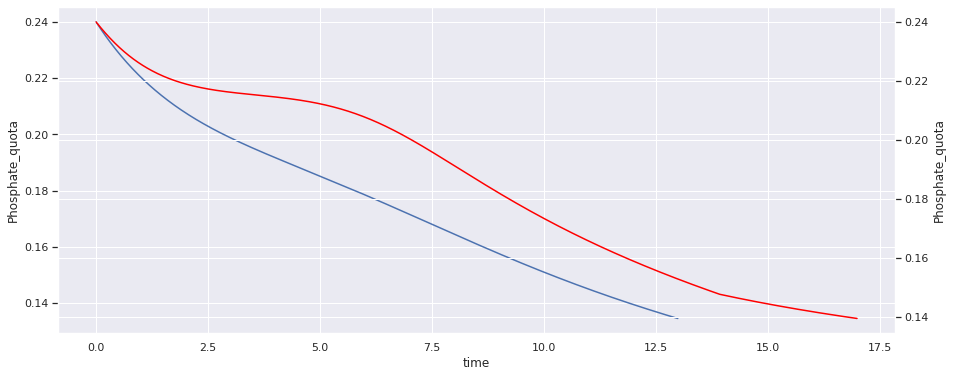

In [216]:
ax = sns.lineplot(x =  concentrations['9'].time, y = concentrations['9']['Phosphate_quota'])
ax = plt.gca().twinx()
sns.lineplot(x=concentrations['11'].time, y=concentrations['11']['Phosphate_quota'], color='red', ax=ax)

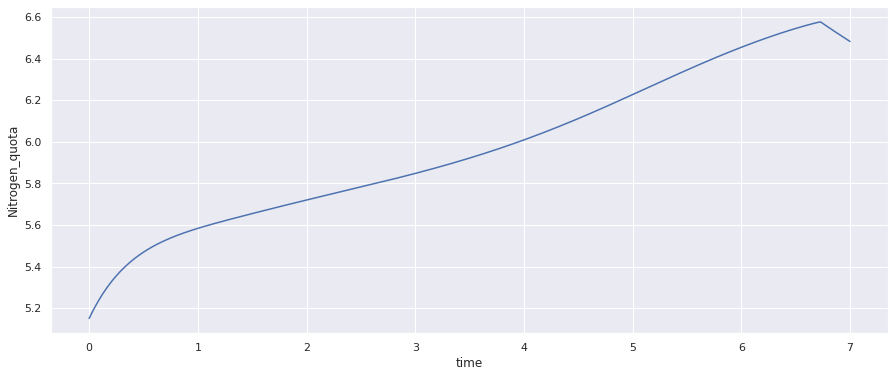

In [297]:
ax = sns.lineplot(x =  concentrations.time, y = concentrations['Nitrogen_quota'])

<AxesSubplot:xlabel='time', ylabel='Nitrogen_quota'>

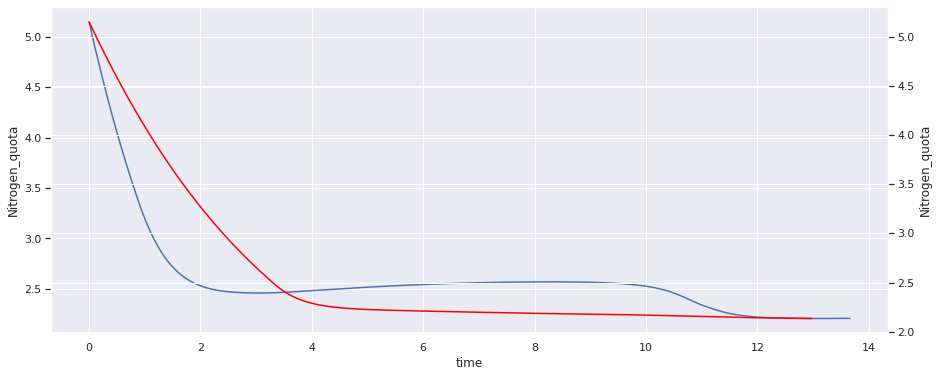

In [184]:
ax = sns.lineplot(x =  concentrations['fachet_LL'].time, y = concentrations['fachet_LL']['Nitrogen_quota'])
ax = plt.gca().twinx()
sns.lineplot(x=concentrations['9'].time, y=concentrations['9']['Nitrogen_quota'], color='red', ax=ax)

In [7]:
st = {
    "1": "0.006112313",
    "2": "0.026350859",
    "3": "0.014449316",
    "4": "0.026350859",
    "5": "0.014449316",
    "6": "0.014789985",
    "7": "0.014449316",
    "8": "0.014789985",
    "9": "0.022663961",
    "10": "0.014789985",
    "11": "0.022663961",
    "12": "0.003563663",
    "13": "0.022663961",
    "14": "0.003563663",
    "15": "0.041744485",
    "16": "0.003563663",
    "17": "0.041744485",
    "18": "0.003208629",
    "20": "0.041744485",
    "22": "0.003208629",
    "23": "0.006232213",
    "24": "0.003208629",
    "RPC1": "0.00221518",
    "RPC2": "0.006232213",
    "RPC3": "0.00221518"
}
std_devs = {key:float(value)/1000 for key, value in st.items()}
error = list(std_devs.values())

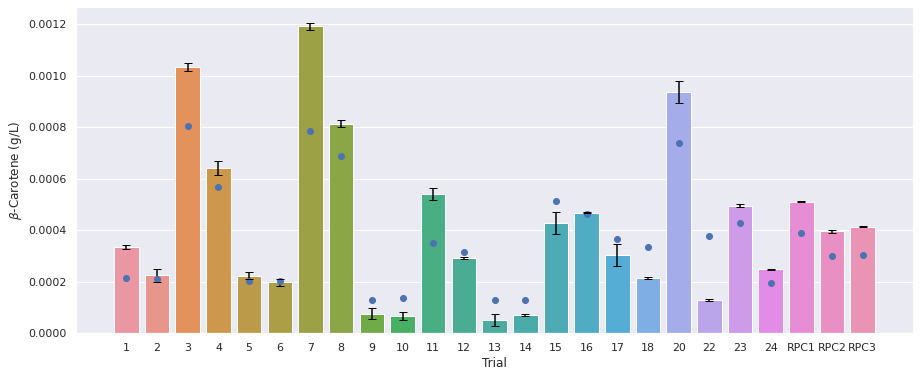

In [154]:
data_carotene = {}
experimental_data = {}
for condition in matrix.conditions.index:
    if "Caro" in matrix.matrix[condition].columns and not condition.startswith("fachet") and not condition.startswith("Xi") and not condition.startswith("Yimei"):
        temp = pd.read_csv(f"{DATA_PATH}/dfba/concentrations_{condition}.csv")
        data_carotene[condition] = temp.iloc[-1]['Carotene'] * temp.iloc[-1]['Biomass']
        experimental_data[condition] = matrix.matrix[condition]['Caro'].dropna().tolist()[-1]*matrix.matrix[condition]['DW'].dropna().tolist()[-1]
ax = plt.subplot(111)
sns.barplot(x = list(experimental_data.keys()), y=list(experimental_data.values()), ci='sd')
plt.errorbar(x = list(experimental_data.keys()), y=list(experimental_data.values()), yerr=error, fmt='none', color='black', capsize=4)
ax.scatter(x = list(data_carotene.keys()), y=list(data_carotene.values()), zorder=2)
plt.ylabel(r"$\beta$-Carotene (g/L)")
plt.xlabel(r"Trial")
plt.savefig("carotene_in_house.png")

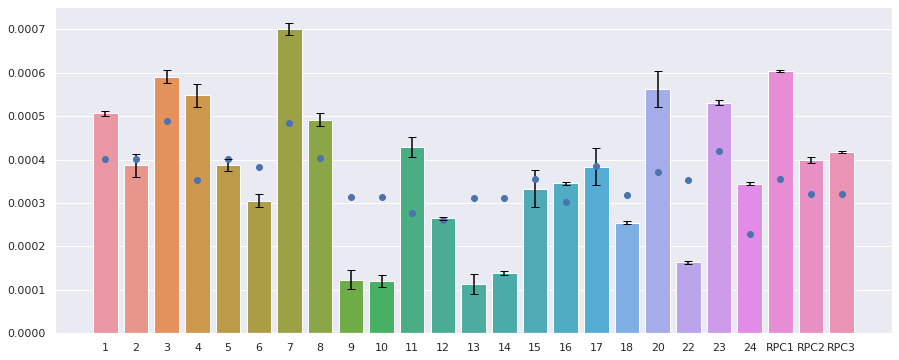

In [36]:
ax = plt.subplot(111)
sns.barplot(x = list(experimental_data.keys()), y=list(experimental_data.values()), ci='sd')
plt.errorbar(x = list(experimental_data.keys()), y=list(experimental_data.values()), yerr=error, fmt='none', color='black', capsize=4)
ax.scatter(x = list(data_carotene.keys()), y=list(data_carotene.values()), zorder=2)

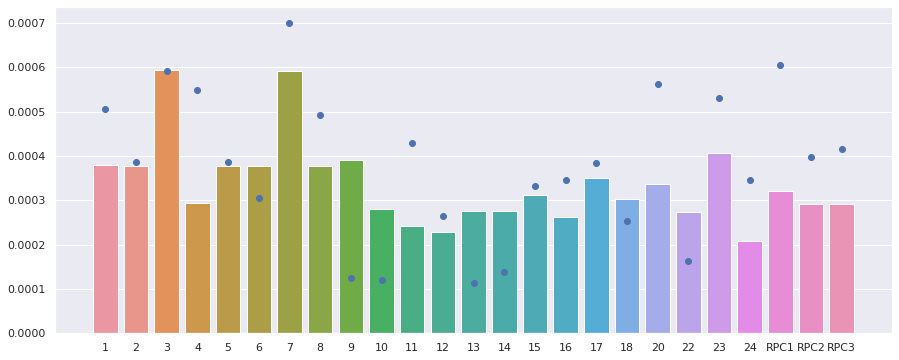

In [155]:
ax = plt.subplot(111)
sns.barplot(x = list(data_carotene.keys()), y=list(data_carotene.values()))
ax.scatter(x = list(experimental_data.keys()), y=list(experimental_data.values()), zorder=2)

In [123]:
experimental_data

{'1': 0.0005064521774171867,
 '2': 0.000386454395145631,
 '3': 0.0005908282499999999,
 '4': 0.0005476258979235586,
 '5': 0.0003868579041007947,
 '6': 0.0003055833290242163,
 '7': 0.0007004719653679653,
 '8': 0.0004917748909011477,
 '9': 0.00012381477300397334,
 '10': 0.00012050952727272728,
 '11': 0.00042913824699699704,
 '12': 0.0002647299181127029,
 '13': 0.00011296603281982227,
 '14': 0.00013887717953618754,
 '15': 0.00033314488364925257,
 '16': 0.0003455931843996982,
 '17': 0.00038367465909090905,
 '18': 0.00025430348967021203,
 '20': 0.000562505293069724,
 '22': 0.00016318537656982195,
 '23': 0.0005308633006019274,
 '24': 0.0003446597206334195,
 'RPC1': 0.0006039994552512261,
 'RPC2': 0.00039854876256472017,
 'RPC3': 0.0004163502799019608}

<AxesSubplot:>

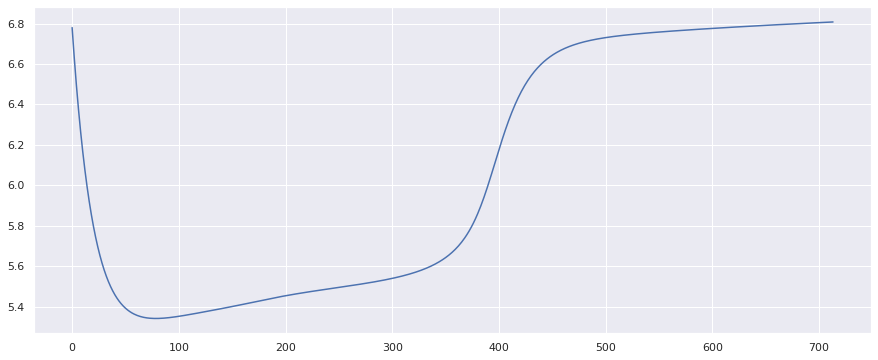

In [8]:
concentrations['Nitrogen_quota'].plot()

In [18]:
d = {
  "ro1": 2.937083999419026,
  "ro0": 0.0748896754788253,
  "a0": 0.06008088061678159,
  "a1": 3.860920575878139e-05,
  "a2": 15.810615183795056,
  "a3": 14.25548623065749,
  "a4": 0.000517861048973313,
  "ExA": 11.79155376659918,
  "l": 1.9178832833821227,
  "smoothing_factor": 3.880195937522119,
  "wPopt": 1.2939851350233573,
  "wPmin": 0.03296645294280451,
  "wNmax": 6.956612084719325,
  "wNmin": 2.2652415910934556,
  "c0": 7.986762128325509e-06,
  "t_max": 1.8205955235004416,
  "K_nitrogen_quota": 0.05035530487850042,
  "VPmax": 0.13495610518661874,
  "KPm": 0.0933396638445216,
  "VNmax": 12.730172812790563,
  "KNm": 0.001328446943255403,
  "wgly_max": 0.1739473024470764,
  "maximum_starch_production": 0.0014119107312425998,
  "maximum_tag_production": 65.62915971101071,
  "v_nitrate_max": 4.538931887092476,
  "v_polyphosphate_max": 0.00016,
  "v_car_max": 0.02409948753126962,
  "ymax": 0.3624636624589128,
  "Esat": 1200.2740889791464,
  "KEchl": 61.588460544435705,
  "vco2max": 124.15110485112281,
  "Kstl": 400,
  "hill_coeff_starch": 2
}

In [19]:
d = {key: round(value, 5) for key, value in d.items()}

In [21]:
json.dumps(d)

'{"ro1": 2.93708, "ro0": 0.07489, "a0": 0.06008, "a1": 4e-05, "a2": 15.81062, "a3": 14.25549, "a4": 0.00052, "ExA": 11.79155, "l": 1.91788, "smoothing_factor": 3.8802, "wPopt": 1.29399, "wPmin": 0.03297, "wNmax": 6.95661, "wNmin": 2.26524, "c0": 1e-05, "t_max": 1.8206, "K_nitrogen_quota": 0.05036, "VPmax": 0.13496, "KPm": 0.09334, "VNmax": 12.73017, "KNm": 0.00133, "wgly_max": 0.17395, "maximum_starch_production": 0.00141, "maximum_tag_production": 65.62916, "v_nitrate_max": 4.53893, "v_polyphosphate_max": 0.00016, "v_car_max": 0.0241, "ymax": 0.36246, "Esat": 1200.27409, "KEchl": 61.58846, "vco2max": 124.1511, "Kstl": 400, "hill_coeff_starch": 2}'

In [6]:
trajectories.head()

,time,e_ActiveBiomass__cytop,EX_C00009__dra,DM_C00369__chlo,DM_C02094__chlo,EX_C00244__dra,DM_C05306__chlo,DM_C05307__chlo,EX_C00011__dra,DM_C00116__cytop,DM_C00404__vacu,DM_C00244__cytop,EX_C00205__dra
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.020833,0.171847,-0.047076,0.000945,0.000406,-3.305404,0.0,0.0,-12.752897,0.205906,-0.000137,1.476456,-1063.617646
2,0.041667,0.171577,-0.046997,0.000942,0.000390,-3.234262,0.0,0.0,-12.712927,0.208759,-0.000137,1.411277,-1059.788818
3,0.062500,0.171305,-0.046918,0.000939,0.000375,-3.166121,0.0,0.0,-12.673852,0.211487,-0.000137,1.348932,-1056.060555
4,0.083333,0.171032,-0.046839,0.000937,0.000362,-3.100845,0.0,0.0,-12.635597,0.214097,-0.000137,1.289331,-1052.423083


<AxesSubplot:>

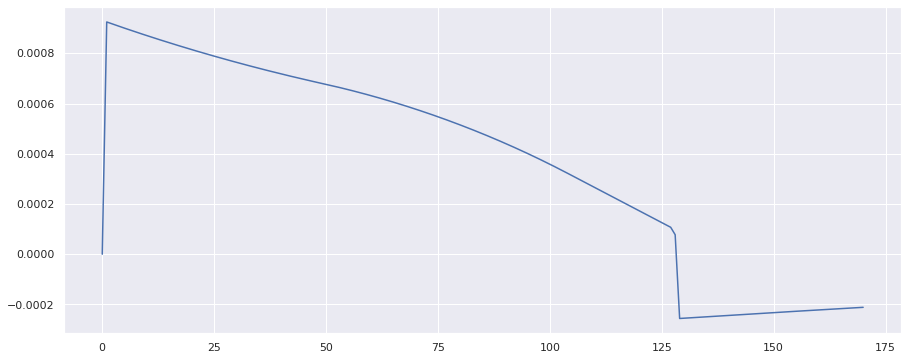

In [39]:
trajectories['DM_C00369__chlo'].plot()

<AxesSubplot:>

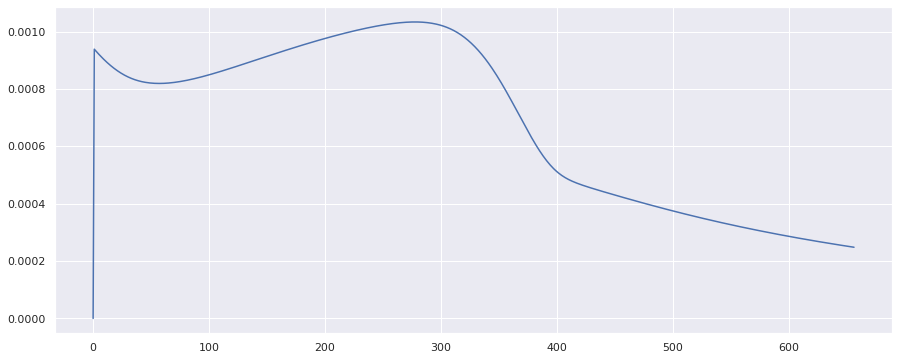

In [13]:
trajectories['DM_C00369__chlo'].plot()

In [103]:
trajectories

,time,e_ActiveBiomass__cytop,EX_C00009__dra,DM_C00369__chlo,DM_C02094__chlo,EX_C00244__dra,DM_C05306__chlo,DM_C05307__chlo,EX_C00011__dra,DM_C00116__cytop,DM_C00404__vacu,DM_C00244__cytop,EX_C00205__dra
0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.020833,2.782698e-01,-0.078298,0.087243,0.045523,-3.093935,0.0,0.000000e+00,-176.627982,0.501533,-0.000139,1.749391,-3049.158701
2,0.041667,2.781382e-01,-0.078255,0.067703,0.045523,-3.806833,0.0,0.000000e+00,-142.317554,0.700986,-0.000139,2.462609,-2480.982404
3,0.062500,2.779934e-01,-0.078208,0.051310,0.045522,-4.283460,0.0,0.000000e+00,-113.309310,0.805602,-0.000139,2.939710,-1979.577344
4,0.083333,2.778375e-01,-0.078157,0.038152,0.045518,-4.589745,0.0,0.000000e+00,-89.894475,0.858604,-0.000140,3.246607,-1591.784260
...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,6.916667,-2.663511e-15,-0.001719,0.000000,0.000147,0.000000,0.0,6.009966e-18,-1.110266,0.127852,0.000069,0.000000,-26.155016
333,6.937500,-3.484143e-15,-0.001672,0.000000,0.000148,0.000000,0.0,7.439954e-18,-1.111445,0.127359,0.000067,0.000000,-26.185970
334,6.958333,-1.464469e-16,-0.001626,0.000000,0.000148,0.000000,0.0,1.826159e-18,-1.112616,0.126867,0.000065,0.000000,-26.216700
335,6.979167,-5.395769e-15,-0.001581,0.000000,0.000148,0.000000,0.0,1.073949e-17,-1.113777,0.126379,0.000063,0.000000,-26.247208


In [299]:
concentrations

,time,ActiveBiomass,Biomass,Carotene,Chlorophyll,Glycerol,Light,Nitrate,Nitrogen_quota,Phosphate,Phosphate_quota,Starch,Starch_concentration,TAG,Protein,Carbohydrate,Lipid
0,0.000000,0.059318,0.076577,0.000600,0.011690,0.150000,0.0,44.641711,5.150000,1.000000e+00,0.240000,0.050000,0.000000,0.013100,0.234769,0.335421,0.154366
1,0.020833,0.060009,0.077551,0.000646,0.011544,0.149368,0.0,44.636739,5.149481,9.998024e-01,0.239537,0.050271,0.000070,0.014371,0.234523,0.335393,0.155489
2,0.041667,0.060709,0.078536,0.000691,0.011399,0.148761,0.0,44.631701,5.148999,9.996022e-01,0.239080,0.050537,0.000140,0.015609,0.234281,0.335364,0.156581
3,0.062500,0.061418,0.079535,0.000736,0.011256,0.148178,0.0,44.626596,5.148561,9.993994e-01,0.238630,0.050797,0.000211,0.016816,0.234042,0.335334,0.157644
4,0.083333,0.062136,0.080545,0.000780,0.011115,0.147616,0.0,44.621424,5.148173,9.991941e-01,0.238187,0.051051,0.000283,0.017991,0.233808,0.335303,0.158678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,14.770833,3.963879,6.094088,0.010112,0.001733,0.052367,0.0,3.651670,6.785560,4.216781e-26,0.167254,0.273221,1.664495,0.011820,0.197137,0.512891,0.130442
710,14.791667,3.965245,6.099075,0.010126,0.001733,0.052404,0.0,3.616203,6.785826,3.443626e-26,0.167118,0.273470,1.667379,0.011827,0.197044,0.513026,0.130393
711,14.812500,3.966612,6.104059,0.010140,0.001733,0.052441,0.0,3.580766,6.786090,2.811715e-26,0.166982,0.273718,1.670257,0.011834,0.196951,0.513161,0.130344
712,14.833333,3.967980,6.109038,0.010155,0.001733,0.052478,0.0,3.545358,6.786355,2.295340e-26,0.166846,0.273964,1.673131,0.011841,0.196858,0.513295,0.130295


In [ ]:
ax= matrix.matrix['fachet_HL'].plot(kind="scatter", x = "Time (d)" ,y='NO3')
temp = concentrations
temp.index = temp['time']
temp['Nitrate'].plot(ax=ax)   

In [ ]:
ax= matrix.matrix['fachet_HL'].plot(kind="scatter", x = "Time (d)" ,y='Caro')
temp = concentrations
temp.index = temp['time']
temp['Carotene'].plot(ax=ax)

In [ ]:
temp['Nitrogen_quota'].plot()

In [ ]:
trajectories

In [158]:
import random


def select_strings(strings, num_to_select, mandatory_strings):
    """
    Selects a specified number of strings from a list, making some of them mandatory.

    Args:
        strings (list): List of strings to select from.
        num_to_select (int): Number of strings to randomly select.
        mandatory_strings (list): List of strings that must be included in the selected strings.

    Returns:
        list: List of selected strings.
    """
    # Check if the number of mandatory strings exceeds the number to select
    if len(mandatory_strings) > num_to_select:
        raise ValueError("Number of mandatory strings cannot exceed number of strings to select.")
    to_ignore = ["fachet", "Xi", "Yimei"]
    strings = [e for e in strings if not any(e.startswith(ignore) for ignore in to_ignore)]
    # Shuffle the input list of strings randomly
    random.shuffle(strings)

    # Select the mandatory strings
    selected = mandatory_strings[:]

    # Select the remaining strings randomly
    remaining = num_to_select - len(mandatory_strings)
    selected.extend(random.sample(strings, remaining))

    return selected

def get_closest(list_A, list_B):
    import numpy as np
    # Initialize an empty list to store the closest values from List B for each number in List A
    closest_values = []
    for num_A in list_A:
        # Find the index of the value in List B that is closest to num_A
        index = np.abs(np.array(list_B) - num_A).argmin()
        # Add the closest value from List B to the closest_values list
        closest_values.append(list_B[index])
    return closest_values

In [286]:
def fitness(model, matrix, initial_parameters):
    parameters = {}
    parameters_names = ('ro1', 'ro0', 'a0', 'a1', 'a2', 'a3', 'a4', 'ExA', 'l', 'smoothing_factor', 'wPopt', 'wPmin', 'wNmax', 'wNmin', 'c0', 't_max', 'K_nitrogen_quota', 'VPmax', 'KPm', 'VNmax', 'KNm', 'wgly_max',
                        'maximum_starch_production', 'maximum_tag_production', 'v_nitrate_max', 'v_polyphosphate_max', "v_car_max", 'ymax', 'Esat', 'KEchl', 'vco2max')
    for i, parameter_name in enumerate(parameters_names):
        parameters[parameter_name] = initial_parameters[i]
    total_error = 0
    conditions_names = tuple(set(matrix.matrix.keys()) - {"Resume"})
    conditions_names = ("fachet_HL",) #'Xi_cont_S','Xi_cont_F', 'fachet_LL'
    try:
        total_error = sum(Parallel(n_jobs=2, timeout=100)(delayed(evaluate_trial)(fba_model, matrix, condition, parameters) for condition in conditions_names))
#         total_error = evaluate_trial(fba_model, matrix, 'fachet_HL', parameters)
    except Exception as e:
        print(e)
        return 1e5
    print(f"Total error from set of parameters: {total_error}")
    return total_error

def evaluate_trial(fba_model, matrix, condition, parameters):
    print(f"Trial: {condition}")
    total_error = 0
    mat = matrix.matrix[condition]
    mat['Time (d)'] = [round(e, 2) for e in mat.index.astype(float)]
    concentrations, trajectories = create_dfba_model(fba_model, matrix, condition, parameters, create_plots=False)
    to_fit = {"Carotene": "Caro"} # , "Carotene": "Caro", "Chlorophyll": "Chl", "Biomass": "DW"
    experimental_time = np.array(mat["Time (d)"])
    closest = get_closest(experimental_time, concentrations.time)
    at_time = concentrations.loc[concentrations.time.isin(closest)]
    at_time.reset_index(inplace=True, drop=True)
    mat.reset_index(inplace=True, drop=True)
    for simulation_name, experimental_name in to_fit.items():
        if experimental_name in mat.columns:
            experimental = mat[experimental_name]
            simulated = at_time[simulation_name]
            total_error += get_relative_error(experimental, simulated)
            print(f"Total error:\n{total_error}")
    return total_error
    
def get_relative_error(experimental, simulated):
    relative_error = 0
    if simulated.shape[0] == 1:
        print(simulated)
        return 1000
    try:
        experimental.dropna(inplace=True)
        simulated = simulated.loc[simulated.index.intersection(experimental.index)]
        abs_error = np.abs(experimental - simulated)
        with np.errstate(divide='ignore', invalid='ignore'):
            relative_error = sum(np.where(experimental == 0, np.inf, abs_error / np.abs(experimental)))
#         print(f"Relative error:\n{relative_error}")
    except Exception as e:
        print(e)
        print(f"Experimental values:\n{experimental}")
        print(f"Simulated values:\n{simulated}")
    if not isinstance(relative_error, numbers.Number):
        print(f"Relative error:\n{relative_error}")
        print(f"Experimental values:\n{experimental}")
        print(f"Simulated values:\n{simulated}")
    if np.isnan(relative_error):
        print("NaN found!!")
        print(f"Experimental values:\n{experimental}")
        print(f"Simulated values:\n{simulated}")
        relative_error = 100
    return relative_error

In [287]:
from scipy.optimize import minimize

matrix = ExpMatrix(f"{DATA_PATH}/experimental/Matriz- DCCR Dunaliella salina_dfba.xlsx")
matrix.conditions = "Resume"


# Define optimization method ('Nelder-Mead', 'BFGS', 'CG', 'L-BFGS-B', etc.)
# Refer to scipy.optimize documentation for more options
method = 'Nelder-Mead'
initial_parameters = json.load(open(f"{DATA_PATH}/dfba/inputs/initial_parameters.json"))
# Define bounds for parameters (if any)
bounds = [(0, 20), (0, 1), (0, 0.5), (0, 0.5), (0, 100), (0, 100),(0, 1), (0, 500), (0, 10), (0, 100), (0, 2), (0, 0.15), (0, 7), (0, 3), (0, 0.05), (1, 4), (0, 1), (0, 1), (0, 0.5), (0, 20), (0, 1), (0, 0.5), (0, 0.1), (0, 100), (0, 10),
              (0, 0.1), (0, 0.5), (0, 1), (100, 1500), (0, 150), (10, 150)]


# Optimize parameters using minimize
max_iterations = 100
result = minimize(partial(fitness, fba_model, matrix), list(initial_parameters.values()), method=method, bounds=bounds, 
                  options={"maxiter": max_iterations})

# Extract optimized parameters and fitness value
optimal_params = result.x
optimal_fitness = result.fun

# Print optimized parameters and fitness value
print("Optimized Parameters: ", optimal_params)
print("Optimized Fitness Value: ", optimal_fitness)




Total error from set of parameters: 112.96354528253607

Total error from set of parameters: 92.28570905884504
Total error from set of parameters: 114.37240044916493
Total error from set of parameters: 100


Total error from set of parameters: 95.54420664437262

Total error from set of parameters: 111.70853248596713




KeyboardInterrupt: 

In [ ]:
{
  "ro1": 200,
  "ro0": 1e-5,
  "a0": 0.0650,
  "a1": 1e-5,
  "a2": 24,
  "a3": 30,
  "l": 2,
  "smoothing_factor": 4,
  "wPopt": 1.295,
  "wPmin": 0.037,
  "wNmax": 6.78,
  "wNmin": 2.29,
  "c0": 1e-5,
  "t_max": 1.74,
  "K_nitrogen_quota": 0.049,
  "VPmax": 0.13,
  "KPm": 0.0185,
  "VNmax": 11.96,
  "KNm": 0.001,
  "wgly_max": 0.17,
  "maximum_starch_production": 0.0015,
  "maximum_tag_production": 49,
  "v_nitrate_max": 4.56,
  "v_polyphosphate_max": 0.0001,
  "v_car_max": 0.072
}


In [73]:
params = {
  "ro1": 199.30197421355496,
  "ro0": 1.0016401833912668e-05,
  "a0": 0.0648498933443255,
  "a1": 9.946515298482242e-06,
  "a2": 24.109515866884703,
  "a3": 30.0582231710872,
  "a4" : 1e-4,
  "ExA": 10.08,
  "l": 2.031377023976839,
  "smoothing_factor": 4.013922724017483,
  "wPopt": 1.2954097121721402,
  "wPmin": 0.0371275968457726,
  "wNmax": 6.793657598258712,
  "wNmin": 2.2895403102696297,
  "c0": 1.000428447444178e-05,
  "t_max": 1.7587810097210947,
  "K_nitrogen_quota": 0.0489039591889132,
  "VPmax": 0.1302747154344762,
  "KPm": 0.0185437965328126,
  "VNmax": 11.992430408506674,
  "KNm": 0.0010102108951295,
  "wgly_max": 0.1704199289543083,
  "maximum_starch_production": 0.0015026600118207,
  "maximum_tag_production": 48.86484336093211,
  "v_nitrate_max": 4.570264065362648,
  "v_polyphosphate_max": 9.9998846789721e-05,
  "v_car_max": 0.071737647981875
}

In [74]:
import math

In [75]:
for key, value in params.items():
    print(math.log2(value))

7.638812190839798
-16.607276128442983
-3.946751988030814
-16.617377394637607
4.5915307759623
4.909687824766218
-13.287712379549449
3.333423733725192
1.0224580289702272
2.0050128422237212
0.37340846566021274
-4.751364252736896
2.764188507922395
1.195057965716478
-16.609022487811757
0.8145758603780542
-4.353904921509457
-2.940370991464808
-5.752919547842758
3.5840521625615467
-9.951127778223277
-2.552834040295521
-9.378265659137439
5.610724961900128
2.1922775251921056
-13.287729016952888
-3.801125744458525
